In [1]:
# Experiment 1 of End-to-end training with the CNNLSTM model model 3.
# Try to find the time and accuracy of the models for different sizes of the dataset under same number of training iterations.
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN LSTM model is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def cnn_LSTM_net(_X, _weights, _biases):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu) 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu) 
    conv2 = tf.transpose(conv2, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
runing_time_list = []
accuracy_list = []
loss_list = []

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 300  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 30000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = cnn_LSTM_net(x,weights,biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            loss, acc = sess.run(
                [cost, accuracy], 
                feed_dict={
                    x: X_test,
                    y: one_hot(y_test)
                }
            )
            test_losses.append(loss)
            test_accuracies.append(acc)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss) + \
                  ", Accuracy = {}".format(acc))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    runing_time_list.append(time.time() - start_time)
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    test_losses.append(final_loss)
    test_accuracies.append(accuracy)

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    accuracy_list.append(accuracy)
    loss_list.append(final_loss)

print("------------------------")
print("FINAL RESULTS LIST:")
print(runing_time_list)
print(accuracy_list)
print(loss_list)

read in the data
(7352, 1)
(735, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 2.426562, Accuracy = 0.14933332800865173
PERFORMANCE ON TEST SET: Batch Loss = 2.3549656867980957, Accuracy = 0.15982355177402496
Training iter #30000:   Batch Loss = 1.202447, Accuracy = 0.6946666836738586
PERFORMANCE ON TEST SET: Batch Loss = 1.2348134517669678, Accuracy = 0.5554801225662231
Training iter #60000:   Batch Loss = 0.817100, Accuracy = 0.8140000104904175
PERFORMANCE ON TEST SET: Batch Loss = 1.0145211219787598, Accuracy = 0.7777400612831116
Training iter #90000:   Batch Loss = 0.706162, Accuracy = 0.8806666731834412
PERFORMANCE ON TEST SET: Batch Loss = 1.022066354751587, Accuracy = 0.80861896276474
Training iter #120000:  

Training iter #600000:   Batch Loss = 0.312185, Accuracy = 0.9953333139419556
PERFORMANCE ON TEST SET: Batch Loss = 0.5976765751838684, Accuracy = 0.9195792078971863
Training iter #630000:   Batch Loss = 0.304169, Accuracy = 0.996666669845581
PERFORMANCE ON TEST SET: Batch Loss = 0.625015139579773, Accuracy = 0.9124533534049988
Training iter #660000:   Batch Loss = 0.296204, Accuracy = 0.996666669845581
PERFORMANCE ON TEST SET: Batch Loss = 0.6085476875305176, Accuracy = 0.9178826212882996
Optimization Finished!
Training time is: 370.1370780467987 seconds
FINAL RESULT: Batch Loss = 0.6129117012023926, Accuracy = 0.9165253043174744
(7352, 1)
(2941, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.858523, Accuracy = 0.14933332800865173
PERFORMANCE ON TEST SET: Batch Loss = 2.710886240005493, Accuracy = 0.16661010682582855
Training iter #30000:   Batch Loss = 1.659389, Accuracy = 0.5406666398048401
PERFORMANCE ON TEST SET: Batch Loss = 1.5995546579360962, Accuracy = 0.56701731

PERFORMANCE ON TEST SET: Batch Loss = 0.5061836242675781, Accuracy = 0.9311164021492004
Training iter #450000:   Batch Loss = 0.299806, Accuracy = 0.9940000176429749
PERFORMANCE ON TEST SET: Batch Loss = 0.511863112449646, Accuracy = 0.9263657927513123
Training iter #480000:   Batch Loss = 0.296450, Accuracy = 0.9933333396911621
PERFORMANCE ON TEST SET: Batch Loss = 0.4883592128753662, Accuracy = 0.9358670115470886
Training iter #510000:   Batch Loss = 0.277511, Accuracy = 1.0
PERFORMANCE ON TEST SET: Batch Loss = 0.47694650292396545, Accuracy = 0.9402782320976257
Training iter #540000:   Batch Loss = 0.276887, Accuracy = 0.996666669845581
PERFORMANCE ON TEST SET: Batch Loss = 0.4821263551712036, Accuracy = 0.9382422566413879
Training iter #570000:   Batch Loss = 0.275461, Accuracy = 0.9906666874885559
PERFORMANCE ON TEST SET: Batch Loss = 0.47415032982826233, Accuracy = 0.9379029273986816
Training iter #600000:   Batch Loss = 0.271016, Accuracy = 0.996666669845581
PERFORMANCE ON TEST 

Training iter #780000:   Batch Loss = 0.259662, Accuracy = 0.9913333058357239
PERFORMANCE ON TEST SET: Batch Loss = 0.33716991543769836, Accuracy = 0.9640312194824219
Training iter #810000:   Batch Loss = 0.239980, Accuracy = 0.9980000257492065
PERFORMANCE ON TEST SET: Batch Loss = 0.34438061714172363, Accuracy = 0.9599592685699463
Training iter #840000:   Batch Loss = 0.238651, Accuracy = 0.9953333139419556
PERFORMANCE ON TEST SET: Batch Loss = 0.30412986874580383, Accuracy = 0.972175121307373
Training iter #870000:   Batch Loss = 0.233248, Accuracy = 0.996666669845581
PERFORMANCE ON TEST SET: Batch Loss = 0.30237719416618347, Accuracy = 0.9667458534240723
Training iter #900000:   Batch Loss = 0.282568, Accuracy = 0.9806666374206543
PERFORMANCE ON TEST SET: Batch Loss = 0.30759677290916443, Accuracy = 0.9650492072105408
Training iter #930000:   Batch Loss = 0.235384, Accuracy = 0.9906666874885559
PERFORMANCE ON TEST SET: Batch Loss = 0.3205040693283081, Accuracy = 0.9592806100845337
T

PERFORMANCE ON TEST SET: Batch Loss = 0.4212356209754944, Accuracy = 0.9491007924079895
Training iter #900000:   Batch Loss = 0.268038, Accuracy = 0.9879999756813049
PERFORMANCE ON TEST SET: Batch Loss = 0.45383572578430176, Accuracy = 0.9446895122528076
Training iter #930000:   Batch Loss = 0.256712, Accuracy = 0.9893333315849304
PERFORMANCE ON TEST SET: Batch Loss = 0.4435201585292816, Accuracy = 0.9429928660392761
Training iter #960000:   Batch Loss = 0.230926, Accuracy = 0.9986666440963745
PERFORMANCE ON TEST SET: Batch Loss = 0.417975515127182, Accuracy = 0.9477434754371643
Training iter #990000:   Batch Loss = 0.228713, Accuracy = 0.9980000257492065
PERFORMANCE ON TEST SET: Batch Loss = 0.431074857711792, Accuracy = 0.9457074999809265
Training iter #1020000:   Batch Loss = 0.232611, Accuracy = 0.9933333396911621
PERFORMANCE ON TEST SET: Batch Loss = 0.45531514286994934, Accuracy = 0.9412962198257446
Training iter #1050000:   Batch Loss = 0.220920, Accuracy = 0.9946666955947876
PE

Training iter #780000:   Batch Loss = 0.302345, Accuracy = 0.9879999756813049
PERFORMANCE ON TEST SET: Batch Loss = 0.41527897119522095, Accuracy = 0.9558873176574707
Training iter #810000:   Batch Loss = 0.299554, Accuracy = 0.984000027179718
PERFORMANCE ON TEST SET: Batch Loss = 0.3994405269622803, Accuracy = 0.9535120725631714
Training iter #840000:   Batch Loss = 0.271092, Accuracy = 0.9980000257492065
PERFORMANCE ON TEST SET: Batch Loss = 0.373835951089859, Accuracy = 0.9609772562980652
Training iter #870000:   Batch Loss = 0.279405, Accuracy = 0.9893333315849304
PERFORMANCE ON TEST SET: Batch Loss = 0.41698962450027466, Accuracy = 0.9450288414955139
Training iter #900000:   Batch Loss = 0.279187, Accuracy = 0.9919999837875366
PERFORMANCE ON TEST SET: Batch Loss = 0.3811950385570526, Accuracy = 0.9511367678642273
Training iter #930000:   Batch Loss = 0.280778, Accuracy = 0.9860000014305115
PERFORMANCE ON TEST SET: Batch Loss = 0.3683550953865051, Accuracy = 0.9558873176574707
Trai

PERFORMANCE ON TEST SET: Batch Loss = 0.5148635506629944, Accuracy = 0.9236511588096619
Training iter #480000:   Batch Loss = 0.338446, Accuracy = 0.9826666712760925
PERFORMANCE ON TEST SET: Batch Loss = 0.4993925094604492, Accuracy = 0.9256871342658997
Training iter #510000:   Batch Loss = 0.331801, Accuracy = 0.984666645526886
PERFORMANCE ON TEST SET: Batch Loss = 0.46751710772514343, Accuracy = 0.9389209151268005
Training iter #540000:   Batch Loss = 0.326178, Accuracy = 0.9826666712760925
PERFORMANCE ON TEST SET: Batch Loss = 0.48600903153419495, Accuracy = 0.9345096945762634
Training iter #570000:   Batch Loss = 0.332226, Accuracy = 0.9793333411216736
PERFORMANCE ON TEST SET: Batch Loss = 0.4925338327884674, Accuracy = 0.9338310360908508
Training iter #600000:   Batch Loss = 0.309586, Accuracy = 0.9866666793823242
PERFORMANCE ON TEST SET: Batch Loss = 0.4438784122467041, Accuracy = 0.9470648169517517
Training iter #630000:   Batch Loss = 0.330035, Accuracy = 0.9806666374206543
PER

Training iter #1950000:   Batch Loss = 0.152586, Accuracy = 0.996666669845581
PERFORMANCE ON TEST SET: Batch Loss = 0.3508039712905884, Accuracy = 0.9429928660392761
Training iter #1980000:   Batch Loss = 0.150254, Accuracy = 0.9953333139419556
PERFORMANCE ON TEST SET: Batch Loss = 0.34123629331588745, Accuracy = 0.9463861584663391
Optimization Finished!
Training time is: 1089.9778270721436 seconds
FINAL RESULT: Batch Loss = 0.34025001525878906, Accuracy = 0.9460468292236328
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.548447, Accuracy = 0.15733332931995392
PERFORMANCE ON TEST SET: Batch Loss = 2.396347999572754, Accuracy = 0.15982355177402496
Training iter #30000:   Batch Loss = 1.432490, Accuracy = 0.6113333106040955
PERFORMANCE ON TEST SET: Batch Loss = 1.4416236877441406, Accuracy = 0.6762809753417969
Training iter #60000:   Batch Loss = 0.959783, Accuracy = 0.7353333234786987
PERFORMANCE ON TEST SET: Batch Loss = 0.8630799651145935, Accuracy = 0.81

PERFORMANCE ON TEST SET: Batch Loss = 0.33225584030151367, Accuracy = 0.9480828046798706
Training iter #1410000:   Batch Loss = 0.188520, Accuracy = 0.9953333139419556
PERFORMANCE ON TEST SET: Batch Loss = 0.34259462356567383, Accuracy = 0.9497794508934021
Training iter #1440000:   Batch Loss = 0.183997, Accuracy = 0.9973333477973938
PERFORMANCE ON TEST SET: Batch Loss = 0.33674541115760803, Accuracy = 0.9548693299293518
Training iter #1470000:   Batch Loss = 0.204469, Accuracy = 0.9826666712760925
PERFORMANCE ON TEST SET: Batch Loss = 0.3330428898334503, Accuracy = 0.9602985978126526
Training iter #1500000:   Batch Loss = 0.177326, Accuracy = 0.9940000176429749
PERFORMANCE ON TEST SET: Batch Loss = 0.31635618209838867, Accuracy = 0.9609772562980652
Training iter #1530000:   Batch Loss = 0.250660, Accuracy = 0.9833333492279053
PERFORMANCE ON TEST SET: Batch Loss = 0.34285205602645874, Accuracy = 0.9545300602912903
Training iter #1560000:   Batch Loss = 0.170948, Accuracy = 0.9980000257

read in the data
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.596522, Accuracy = 0.14533333480358124
PERFORMANCE ON TEST SET: Batch Loss = 2.5457639694213867, Accuracy = 0.1425178200006485
Training iter #300000:   Batch Loss = 0.500984, Accuracy = 0.9326666593551636
PERFORMANCE ON TEST SET: Batch Loss = 0.5463629961013794, Accuracy = 0.9155073165893555
Training iter #600000:   Batch Loss = 0.334970, Accuracy = 0.9826666712760925
PERFORMANCE ON TEST SET: Batch Loss = 0.467978298664093, Accuracy = 0.9477434754371643
Training iter #900000:   Batch Loss = 0.257485, Accuracy = 0.9900000095367432
PERFORMANCE ON TEST SET: Batch Loss = 0.41076499223709106, Accuracy = 0.9521547555923462
Training iter #1200000:   Batch Loss = 0.219698, Accuracy = 0.9860000014305115
PERFORMANCE ON TEST SET: Batch Loss = 0.390073299407959, Accuracy = 0.9446895122528076
Training iter #1500000:   Batch Loss = 0.184680, Accuracy = 0.9940000176429749
PERFORMANCE ON TEST SET: Batch Loss

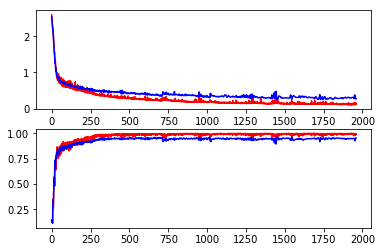

In [4]:
# Experiment 2 Part 1 of End-to-end training with the CNNLSTM model model 3.
# Finding the optimal number of iterations for Model 3
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN LSTM model is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def cnn_LSTM_net(_X, _weights, _biases):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu) 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu) 
    conv2 = tf.transpose(conv2, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 400  # Loop 400 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = cnn_LSTM_net(x,weights,biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    plt.figure(1)
    plt.subplot(211)
    plt.plot(np.arange(0,len(train_losses),1), train_losses, 'r', np.arange(0,len(test_losses),1), test_losses, 'b')
    plt.subplot(212)
    plt.plot(np.arange(0,len(train_accuracies),1), train_accuracies, 'r', np.arange(0,len(test_accuracies),1), test_accuracies, 'b')
    plt.show()

In [9]:
# Save above results for manuscript plotting later.

import pyexcel as pe

sheet = pe.Sheet([[train_accuracies[i], test_accuracies[i],train_losses[i],test_losses[i]] for i in range(0,len(train_accuracies))])
sheet.save_as("CNN_LSTM_Training_ACC_LOSS.csv")


In [10]:
# Experiment 2 Part 2 of End-to-end training with the CNNLSTM model model 3.
# Try to find the time and accuracy of the models for different sizes of the dataset 
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN LSTM model is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def cnn_LSTM_net(_X, _weights, _biases):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu)
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu)
    conv2 = tf.transpose(conv2, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
runing_time_list = []
accuracy_list = []
loss_list = []

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 200  # Loop 200 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = cnn_LSTM_net(x,weights,biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            loss, acc = sess.run(
                [cost, accuracy], 
                feed_dict={
                    x: X_test,
                    y: one_hot(y_test)
                }
            )
            test_losses.append(loss)
            test_accuracies.append(acc)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss) + \
                  ", Accuracy = {}".format(acc))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    runing_time_list.append(time.time() - start_time)
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    test_losses.append(final_loss)
    test_accuracies.append(accuracy)

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    accuracy_list.append(accuracy)
    loss_list.append(final_loss)

print("------------------------")
print("FINAL RESULTS LIST:")
print(runing_time_list)
print(accuracy_list)
print(loss_list)

read in the data
(7352, 1)
(735, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.510424, Accuracy = 0.20399999618530273
PERFORMANCE ON TEST SET: Batch Loss = 2.4413578510284424, Accuracy = 0.16830675303936005
Optimization Finished!
Training time is: 86.01405668258667 seconds
FINAL RESULT: Batch Loss = 0.940360963344574, Accuracy = 0.7964031100273132
(7352, 1)
(1470, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.850456, Accuracy = 0.15333333611488342
PERFORMANCE ON TEST SET: Batch Loss = 2.746682643890381, Accuracy = 0.15982355177402496
Optimization Finished!
Training time is: 167.23733615875244 seconds
FINAL RESULT: Batch Loss = 0.7051725387573242, Accuracy = 0.8758059144020081
(7352, 1)
(2206, 128, 9)
start training
Training iter #1500:   Batch Loss = 2.488543, Accuracy = 0.1653333306312561
PERFORMANCE ON TEST SET: Batch Loss = 2.379026174545288, Accuracy = 0.18221920728683472
Training iter #300000:   Batch Loss = 0.392660, Accuracy = 0.9833333492279053
PER

In [11]:
# Save above results for manuscript plotting later.

import pyexcel as pe

sheet = pe.Sheet([[runing_time_list[i], accuracy_list[i],loss_list[i]] for i in range(0,len(runing_time_list))])
sheet.save_as("CNN_LSTM_Mod_Time_ACC_LOSS.csv")

In [1]:
# Plot the confusion matrix to take a look
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The CNN model is written by myself

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

def cnn_LSTM_net(_X, _weights, _biases):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu) 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2)
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu)
    conv2 = tf.transpose(conv2, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 400  # Loop 500 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = cnn_LSTM_net(x,weights,biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    predictions = one_hot_predictions.argmax(1)
    
    print("Testing Accuracy: {}%".format(100*accuracy))

    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

read in the data
(7352, 1)
(7352, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 2.410534, Accuracy = 0.14933332800865173
PERFORMANCE ON TEST SET: Batch Loss = 2.3403375148773193, Accuracy = 0.16661010682582855
Training iter #300000:   Batch Loss = 0.400829, Accuracy = 0.9819999933242798
PERFORMANCE ON TEST SET: Batch Loss = 0.626539945602417, Accuracy = 0.9155073165893555
Training iter #600000:   Batch Loss = 0.326681, Accuracy = 0.9886666536331177
PERFORMANCE ON TEST SET: Batch Loss = 0.5435868501663208, Accuracy = 0.9267051219940186
Training iter #900000:   Batch Loss = 0.249756, Accuracy = 0.9933333396911621
PERFORMANCE ON TEST SET: Batch Loss = 0.5159831047058105, Accuracy = 0.9328130483627319
Training iter #120

<Figure size 1200x1200 with 2 Axes>

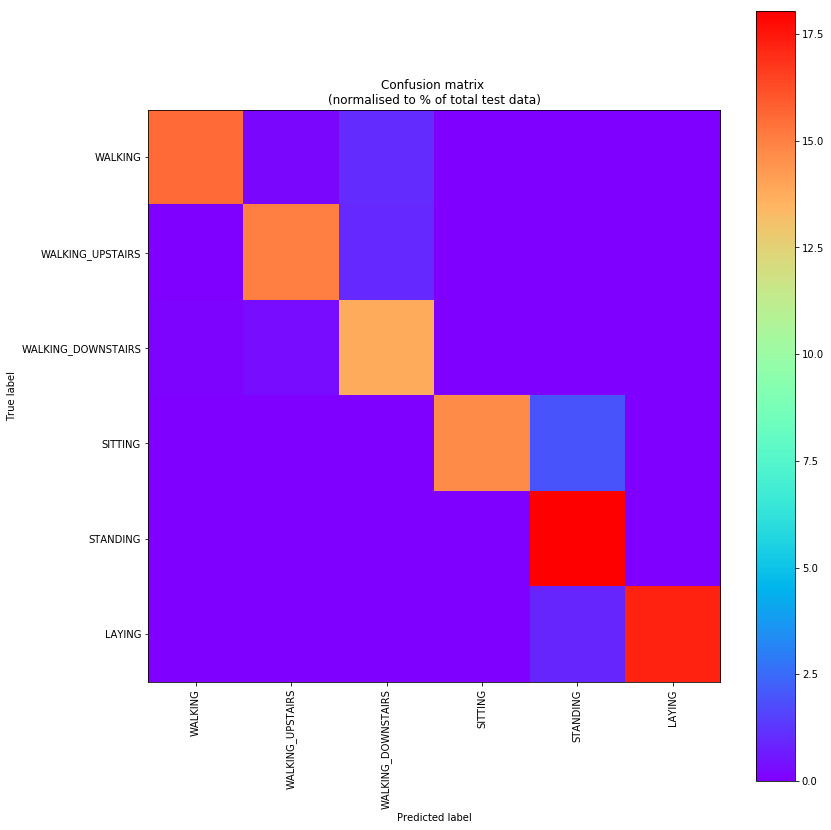

In [2]:
width = 12
height = 12
f = plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
f.savefig("cnnlstm_conf.pdf", bbox_inches='tight')
f.savefig("cnnlstm_conf.png", bbox_inches='tight')